In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [73]:
pre_df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [74]:
# preprocess dataframe - duration and month
pre_df["arrivalDate"] = pd.to_datetime(pre_df["arrivalDate"])
pre_df["sailingDate"] = pd.to_datetime(pre_df["sailingDate"])
pre_df["duration"] = pd.to_datetime(pre_df["sailingDate"]) - pd.to_datetime(pre_df["arrivalDate"])
pre_df["month"] = pre_df["arrivalDate"].dt.month
pre_df['day'] = pre_df['arrivalDate'].dt.day
pre_df['week'] = pre_df['arrivalDate'].dt.isocalendar().week
pre_df['quarter'] = pre_df['arrivalDate'].dt.quarter

pre_df['day'] = pre_df['day'].astype(int)
pre_df['week'] = pre_df['week'].astype(int)
pre_df['quarter'] = pre_df['quarter'].astype(int)

In [75]:
pre_df['duration'] = pre_df['duration'] / pd.Timedelta(days=1)

In [76]:
# drop null values in df
pre_df.dropna(inplace=True)

In [77]:
# preprocess data
# sort by imo number
pre_df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
pre_df['next_unlocode'] = pre_df.groupby('IMO')['place.unlocode'].shift(-1)
pre_df['is_last_imo'] = pre_df['IMO'] != pre_df['IMO'].shift(-1)
pre_df = pre_df[~pre_df["is_last_imo"]]
pre_df = pre_df[pre_df["Event_Type"] != "ARRIVAL"]

In [78]:
pre_df.columns

Index(['arrivalDate', 'sailingDate', 'place.placeName', 'place.unlocode',
       'place.placeType', 'place.countryName', 'Timestamp', 'Event_Type',
       'IMO', 'vessel.vesselName', 'vessel.vesselType', 'duration', 'month',
       'day', 'week', 'quarter', 'next_unlocode', 'is_last_imo'],
      dtype='object')

In [79]:
pre_df

,arrivalDate,sailingDate,place.placeName,place.unlocode,place.placeType,place.countryName,Timestamp,Event_Type,IMO,vessel.vesselName,vessel.vesselType,duration,month,day,week,quarter,next_unlocode,is_last_imo
314761,2023-01-18 14:10:05,2023-01-26 04:05:00,Los Angeles,USLAX,Port,United States of America,2023-01-26T04:05:00,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),7.579803,1,18,3,1,CNJGY,False
314763,2023-02-22 07:17:58,2023-02-23 18:56:16,Jiangyin,CNJGY,Port,People's Republic of China,2023-02-23T18:56:16,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),1.484931,2,22,8,1,CNTXG,False
314765,2023-03-02 16:00:39,2023-03-03 12:31:09,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,2023-03-03T12:31:09,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),0.854514,3,2,9,1,CNQAW,False
314767,2023-03-04 21:02:13,2023-03-05 11:45:29,Qianwan,CNQAW,Sub Port,People's Republic of China,2023-03-05T11:45:29,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),0.613380,3,4,9,1,CNMSN,False
314769,2023-03-06 23:30:18,2023-03-08 00:00:46,Meishan,CNMSN,Sub Port,People's Republic of China,2023-03-08T00:00:46,DEPARTURE,1026764,Max 08,Vessel Type (unspecified),1.021157,3,6,10,1,CNNSA,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,2023-09-05 05:50:48,2023-09-06 02:46:03,Port Klang (Pelabuhan Klang),MYPKG,Port,Malaysia,2023-09-06T02:46:03,DEPARTURE,9951135,Asterios,fully cellular containership,0.871701,9,5,36,3,INMAA,False
12571,2023-09-10 16:43:35,2023-09-11 20:02:20,Chennai (ex Madras),INMAA,Port,India,2023-09-11T20:02:20,DEPARTURE,9951135,Asterios,fully cellular containership,1.138021,9,10,36,3,BDCGP,False
12573,2023-09-15 05:31:56,2023-09-17 05:28:29,Chittagong (Chattogram),BDCGP,Port,Bangladesh,2023-09-17T05:28:29,DEPARTURE,9951135,Asterios,fully cellular containership,1.997604,9,15,37,3,THLCH,False
12575,2023-09-24 15:15:36,2023-09-25 08:23:38,Laem Chabang,THLCH,Port,Thailand,2023-09-25T08:23:38,DEPARTURE,9951135,Asterios,fully cellular containership,0.713912,9,24,38,3,SGSIN,False


In [80]:
pre_df = pre_df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate"])
pre_df

,place.placeName,place.unlocode,place.placeType,place.countryName,vessel.vesselType,duration,month,day,week,quarter,next_unlocode
314761,Los Angeles,USLAX,Port,United States of America,Vessel Type (unspecified),7.579803,1,18,3,1,CNJGY
314763,Jiangyin,CNJGY,Port,People's Republic of China,Vessel Type (unspecified),1.484931,2,22,8,1,CNTXG
314765,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,Vessel Type (unspecified),0.854514,3,2,9,1,CNQAW
314767,Qianwan,CNQAW,Sub Port,People's Republic of China,Vessel Type (unspecified),0.613380,3,4,9,1,CNMSN
314769,Meishan,CNMSN,Sub Port,People's Republic of China,Vessel Type (unspecified),1.021157,3,6,10,1,CNNSA
...,...,...,...,...,...,...,...,...,...,...,...
12569,Port Klang (Pelabuhan Klang),MYPKG,Port,Malaysia,fully cellular containership,0.871701,9,5,36,3,INMAA
12571,Chennai (ex Madras),INMAA,Port,India,fully cellular containership,1.138021,9,10,36,3,BDCGP
12573,Chittagong (Chattogram),BDCGP,Port,Bangladesh,fully cellular containership,1.997604,9,15,37,3,THLCH
12575,Laem Chabang,THLCH,Port,Thailand,fully cellular containership,0.713912,9,24,38,3,SGSIN


In [81]:
df = pre_df.rename(columns={'place.unlocode':'current_unlocode', 'place.placeName':'port_name','vessel.vesselType':'vesselType', 'place.placeType': 'placeType', 'place.countryName': 'countryName'})
df

,port_name,current_unlocode,placeType,countryName,vesselType,duration,month,day,week,quarter,next_unlocode
314761,Los Angeles,USLAX,Port,United States of America,Vessel Type (unspecified),7.579803,1,18,3,1,CNJGY
314763,Jiangyin,CNJGY,Port,People's Republic of China,Vessel Type (unspecified),1.484931,2,22,8,1,CNTXG
314765,Tianjin Xingang Port,CNTXG,Port,People's Republic of China,Vessel Type (unspecified),0.854514,3,2,9,1,CNQAW
314767,Qianwan,CNQAW,Sub Port,People's Republic of China,Vessel Type (unspecified),0.613380,3,4,9,1,CNMSN
314769,Meishan,CNMSN,Sub Port,People's Republic of China,Vessel Type (unspecified),1.021157,3,6,10,1,CNNSA
...,...,...,...,...,...,...,...,...,...,...,...
12569,Port Klang (Pelabuhan Klang),MYPKG,Port,Malaysia,fully cellular containership,0.871701,9,5,36,3,INMAA
12571,Chennai (ex Madras),INMAA,Port,India,fully cellular containership,1.138021,9,10,36,3,BDCGP
12573,Chittagong (Chattogram),BDCGP,Port,Bangladesh,fully cellular containership,1.997604,9,15,37,3,THLCH
12575,Laem Chabang,THLCH,Port,Thailand,fully cellular containership,0.713912,9,24,38,3,SGSIN


In [82]:
# data statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170752 entries, 314761 to 12577
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   port_name         170752 non-null  object 
 1   current_unlocode  170752 non-null  object 
 2   placeType         170752 non-null  object 
 3   countryName       170752 non-null  object 
 4   vesselType        170752 non-null  object 
 5   duration          170752 non-null  float64
 6   month             170752 non-null  int32  
 7   day               170752 non-null  int32  
 8   week              170752 non-null  int32  
 9   quarter           170752 non-null  int32  
 10  next_unlocode     170752 non-null  object 
dtypes: float64(1), int32(4), object(6)
memory usage: 13.0+ MB


In [83]:
# print out the stats related to port appearance
print(df['current_unlocode'].value_counts().describe())

count    1772.000000
mean       96.361174
std       350.567438
min         1.000000
25%         3.000000
50%        11.000000
75%        54.000000
max      8980.000000
Name: count, dtype: float64


In [84]:
# Calculate frequency of each port for thresholding
port_counts = pd.concat([df['current_unlocode'], df['next_unlocode']]).value_counts()

threshold = 1000
print(threshold)

# Filter ports that meet the threshold
valid_ports_df = port_counts[port_counts >= threshold]
valid_ports = port_counts[port_counts >= threshold].index
# Keep only rows where both current and next ports are in valid_ports
filtered_df = df[(df['current_unlocode'].isin(valid_ports)) & (df['next_unlocode'].isin(valid_ports))]
valid_ports_df


1000


SGSIN     17961
PA PCN     6705
USLGB      6387
CNSGH      6015
KRBNP      5579
          ...  
ECESM      1065
SADMM      1053
PECLL      1023
CNMWN      1018
CNCWN      1000
Name: count, Length: 71, dtype: int64

In [85]:
# uniqueness check
print(len(valid_ports))
print(len(set(valid_ports)))

71
71


In [86]:
# value counts of filtered_df
vc_filtered_df = pd.concat([filtered_df['current_unlocode'], filtered_df['next_unlocode']]).value_counts()
vc_filtered_df

SGSIN    11943
CNBEI     5078
KRBNP     4840
CNYSN     4747
CNSGH     4735
         ...  
AUPOR      389
SADMM      376
ZADUR      274
BRSSZ      223
PECLL      209
Name: count, Length: 71, dtype: int64

In [87]:
# Select a certain number of samples for each port
# Initialize an empty list to store the rows before creating the final DataFrame
rows_to_add = []

# Track how many times each port has been added
port_usage = {port: 0 for port in valid_ports}

# Shuffle the data to randomize the sampling
filtered_df = filtered_df.sample(frac=1, random_state=42)

for _, row in filtered_df.iterrows():
    current_port = row['current_unlocode']
    next_port = row['next_unlocode']
    # Check if both ports in the row can still be added
    if port_usage[current_port] < 200 and port_usage[next_port] < 200:
        rows_to_add.append(row)
        # Update the usage count for both ports
        port_usage[current_port] += 1
        port_usage[next_port] += 1

        # Stop adding if both have reached the limit
        if all(count >= 100 for count in port_usage.values()):
            break

# Create the final DataFrame from the list of rows
balanced_df = pd.DataFrame(rows_to_add)

# Reset index after all operations
balanced_df = balanced_df.reset_index(drop=True)

# Print value counts to confirm balancing
df_bal_counts = pd.concat([balanced_df['current_unlocode'], balanced_df['next_unlocode']]).value_counts()
df_bal_counts.describe()
df_bal_counts

USHOU    201
SGSIN    201
ECESM    201
GBSOU    201
CAVAN    201
        ... 
ZADUR    122
CNMWN    114
CNCWN    106
PECLL     85
BRSSZ     83
Name: count, Length: 71, dtype: int64

In [88]:
print(df_bal_counts.describe())
df_bal_counts.quantile(0.15)

count     71.000000
mean     187.521127
std       28.254890
min       83.000000
25%      200.000000
50%      200.000000
75%      200.000000
max      201.000000
Name: count, dtype: float64


164.5

In [89]:
threshold = 200
# filter ports again to remove ports in balanced_df that are not above a certain threshold from df_bal_counts
valid_ports_bal_df = df_bal_counts[df_bal_counts >= threshold]
valid_ports_bal = df_bal_counts[df_bal_counts >= threshold].index
# Keep only rows where both current and next ports are in valid_ports
filtered_bal_df = balanced_df[(balanced_df['current_unlocode'].isin(valid_ports_bal)) & (balanced_df['next_unlocode'].isin(valid_ports_bal))]
valid_ports_bal_df

USHOU     201
SGSIN     201
ECESM     201
GBSOU     201
CAVAN     201
CNTXG     201
INMUN     201
DEBRV     201
THLCH     200
CNYTN     200
CNSHK     200
TWKHH     200
LKCMB     200
AEKHL     200
KRBNP     200
USPNJ     200
MYPKG     200
BEZEE     200
USCHS     200
CNQAW     200
BEANR     200
CNNSA     200
KRPTK     200
JPYOK     200
USBAL     200
KRKAN     200
NLRTM     200
JPUKB     200
PAONX     200
AUPBN     200
USTIW     200
MXZLO     200
KRYOS     200
VNTOT     200
MXLZC     200
KRUSN     200
USLGB     200
CNSGH     200
CNXMG     200
KRONS     200
USSAV     200
AEJEA     200
JPNGO     200
JPTYO     200
CNZOS     200
INNSA     200
USLAX     200
PA PCN    200
USOAK     200
HKHKG     200
MYTPP     200
CNYSN     200
FRLEH     200
CNBEI     200
Name: count, dtype: int64

In [90]:
df = filtered_bal_df

In [91]:
filtered_bal_df

,port_name,current_unlocode,placeType,countryName,vesselType,duration,month,day,week,quarter,next_unlocode
0,Yeosu,KRYOS,Port,Republic of Korea,Combined chemical and oil tanker,2.870428,4,28,17,2,KRONS
1,Yantian Port,CNYTN,Port,People's Republic of China,fully cellular containership,0.878356,12,1,48,4,PA PCN
3,Ulsan,KRUSN,Port,Republic of Korea,vehicle carrier,0.325683,7,1,26,3,USTIW
6,Long Beach,USLGB,Port,United States of America,vehicle carrier,0.655486,6,30,26,2,USLGB
7,Shanghai,CNSGH,Port,People's Republic of China,fully cellular containership,0.510532,7,21,29,3,TWKHH
...,...,...,...,...,...,...,...,...,...,...,...
6566,Tacoma,USTIW,Port,United States of America,bulk carrier,0.229595,10,20,42,4,USTIW
6575,Colon,PAONX,Port,Panama,fully cellular containership,0.587616,2,11,6,1,PAONX
6585,Tacoma,USTIW,Port,United States of America,fully cellular containership,5.807292,9,25,38,3,USTIW
6595,Colon,PAONX,Port,Panama,vehicle carrier,0.558692,2,16,7,1,PAONX


In [92]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Encode categorical features
label_encoders = {}
for column in ['port_name', 'placeType', 'countryName', 'vesselType']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

C:\Users\syeda\AppData\Local\Temp\ipykernel_21324\3627801224.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\syeda\AppData\Local\Temp\ipykernel_21324\3627801224.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\syeda\AppData\Local\Temp\ipykernel_21324\3627801224.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [93]:
# manually map everything to integers for unlocode
# Combine both columns to find all unique ports
all_ports = pd.concat([df['current_unlocode'], df['next_unlocode']])

# Create unique identifiers for each port
unique_ports = all_ports.unique()
port_to_id = {port: i for i, port in enumerate(unique_ports)}

df['encoded_current_unlocode'] = df['current_unlocode'].map(port_to_id)
df['encoded_next_unlocode'] = df['next_unlocode'].map(port_to_id)

# Print the first few rows of the DataFrame to verify the encoding
print(df.head())


   port_name current_unlocode  placeType  countryName  vesselType  duration  \
0         50            KRYOS          0           14           0  2.870428   
1         49            CNYTN          0           13           7  0.878356   
3         45            KRUSN          0           14          14  0.325683   
6         20            USLGB          0           21          14  0.655486   
7         37            CNSGH          0           13           7  0.510532   

   month  day  week  quarter next_unlocode  encoded_current_unlocode  \
0      4   28    17        2         KRONS                         0   
1     12    1    48        4        PA PCN                         1   
3      7    1    26        3         USTIW                         2   
6      6   30    26        2         USLGB                         3   
7      7   21    29        3         TWKHH                         4   

   encoded_next_unlocode  
0                      6  
1                     15  
3          

C:\Users\syeda\AppData\Local\Temp\ipykernel_21324\2382646095.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_current_unlocode'] = df['current_unlocode'].map(port_to_id)
C:\Users\syeda\AppData\Local\Temp\ipykernel_21324\2382646095.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_next_unlocode'] = df['next_unlocode'].map(port_to_id)


In [94]:
ports = df[['current_unlocode', 'encoded_current_unlocode', 'next_unlocode', 'encoded_next_unlocode']]
ports

,current_unlocode,encoded_current_unlocode,next_unlocode,encoded_next_unlocode
0,KRYOS,0,KRONS,6
1,CNYTN,1,PA PCN,15
3,KRUSN,2,USTIW,52
6,USLGB,3,USLGB,3
7,CNSGH,4,TWKHH,29
...,...,...,...,...
6566,USTIW,52,USTIW,52
6575,PAONX,50,PAONX,50
6585,USTIW,52,USTIW,52
6595,PAONX,50,PAONX,50


In [95]:
df = df.drop(columns=['current_unlocode', 'next_unlocode'])

In [96]:
df = df.drop(columns=['placeType'])

In [97]:
# Prepare features and target variable
X = df.drop(['encoded_next_unlocode'], axis=1)
y = df['encoded_next_unlocode']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [98]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [99]:
X_train

array([[0.86792453, 0.09090909, 0.85714286, ..., 0.32692308, 0.33333333,
        0.37735849],
       [0.58490566, 0.95454545, 0.5       , ..., 0.40384615, 0.33333333,
        0.62264151],
       [0.79245283, 0.40909091, 0.5       , ..., 0.34615385, 0.33333333,
        0.32075472],
       ...,
       [0.09433962, 1.        , 0.5       , ..., 0.        , 0.        ,
        0.43396226],
       [0.8490566 , 0.63636364, 0.35714286, ..., 0.59615385, 0.66666667,
        0.03773585],
       [0.39622642, 0.95454545, 0.85714286, ..., 0.59615385, 0.66666667,
        0.24528302]])

In [100]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [101]:
params = {
    'max_depth': 5,  # Slightly increase max depth
    'objective': 'multi:softmax',
    'num_class': len(unique_ports),
    'eval_metric': ['merror', 'mlogloss'],
    'nthread': 4,
    'verbosity': 1,
    'lambda': 15.0,  # Further increase L2 regularization
    'alpha': 10.0,   # Further increase L1 regularization
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'learning_rate': 0.01,  # Further reduce learning rate
    'device': 'cuda'  # Change to 'cpu' if not using GPU
}

In [102]:
num_rounds = 200  # Reduce number of rounds
evals = [(dtrain, 'train'), (dtest, 'test')]
evals_result = {}

# Train the model with evaluation metrics
xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, early_stopping_rounds=10, evals_result=evals_result, verbose_eval=True)

[0]	train-merror:0.73343	train-mlogloss:3.98337	test-merror:0.74275	test-mlogloss:3.98384
[1]	train-merror:0.70656	train-mlogloss:3.97721	test-merror:0.72288	test-mlogloss:3.97834
[2]	train-merror:0.69437	train-mlogloss:3.97147	test-merror:0.71536	test-mlogloss:3.97310
[3]	train-merror:0.70154	train-mlogloss:3.96540	test-merror:0.71912	test-mlogloss:3.96755
[4]	train-merror:0.70154	train-mlogloss:3.95939	test-merror:0.72288	test-mlogloss:3.96215
[5]	train-merror:0.69832	train-mlogloss:3.95391	test-merror:0.72395	test-mlogloss:3.95729
[6]	train-merror:0.70262	train-mlogloss:3.94900	test-merror:0.72180	test-mlogloss:3.95295
[7]	train-merror:0.70369	train-mlogloss:3.94317	test-merror:0.72073	test-mlogloss:3.94763
[8]	train-merror:0.69903	train-mlogloss:3.93766	test-merror:0.71966	test-mlogloss:3.94260
[9]	train-merror:0.70262	train-mlogloss:3.93205	test-merror:0.72395	test-mlogloss:3.93753
[10]	train-merror:0.68972	train-mlogloss:3.92643	test-merror:0.70945	test-mlogloss:3.93228
[11]	trai

In [103]:
# Predict the labels of the test set
y_pred = xgb_model.predict(dtest)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.32


Accuracy: 0.32


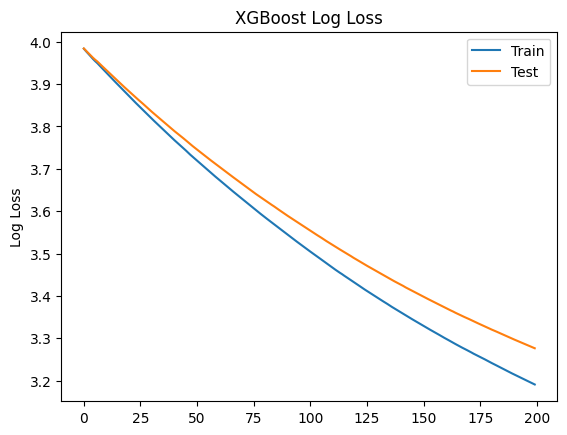

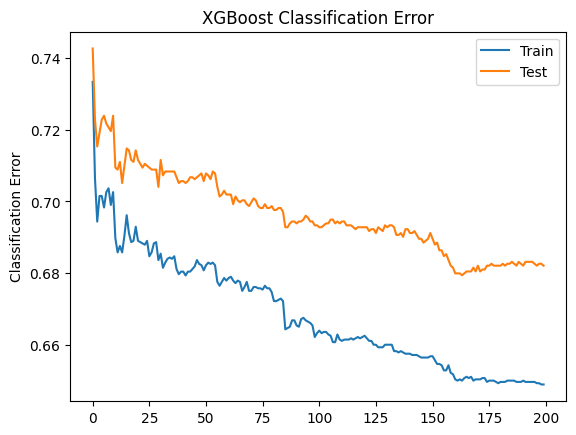

In [104]:
# Predict the labels of the test set
y_pred = xgb_model.predict(dtest)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Retrieve performance metrics
epochs = len(evals_result['train']['merror'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
ax.plot(x_axis, evals_result['test']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# Plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['merror'], label='Train')
ax.plot(x_axis, evals_result['test']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [105]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(xgb.XGBClassifier(**params), X, y, cv=skf, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cross_val_results.mean():.2f} (+/- {cross_val_results.std() * 2:.2f})')

Cross-Validation Accuracy: 0.33 (+/- 0.01)
